Link to the dataset used: https://www.ll.mit.edu/r-d/datasets/vpnnonvpn-network-application-traffic-dataset-vnat

## Creating a script to process PCAP files

In [ ]:
%%writefile pcap_gobbler.sh
#!/bin/bash

if [ "$#" -ne 3 ]; then
    echo "Usage: $0 <input_directory> <output_csv_file> <python_script>"
    exit 1
fi

INPUT_DIR="$1"
OUTPUT_FILE="$2"
PYTHON_SCRIPT="$3"

SCRIPT_DIR="$(dirname "$0")"
TEMP_FILE="$SCRIPT_DIR/temp_output.csv"

if [ ! -f "$PYTHON_SCRIPT" ]; then
    echo "Python script $PYTHON_SCRIPT not found."
    exit 1
fi

if [ -f "$OUTPUT_FILE" ]; then
    rm "$OUTPUT_FILE"
fi

HEADER_WRITTEN=false

if [ ! -d "$INPUT_DIR" ]; then
    echo "Input directory $INPUT_DIR does not exist."
    exit 1
fi

for file in "$INPUT_DIR"/*.pcap; do
    if [ ! -e "$file" ]; then
        echo "No .pcap files found in $INPUT_DIR"
        exit 1
    fi

    echo "Processing $file..."

    python3.9 "$PYTHON_SCRIPT" "$file" "$TEMP_FILE"

    if [ -f "$TEMP_FILE" ]; then
        if [ "$HEADER_WRITTEN" = false ]; then
            cat "$TEMP_FILE" >> "$OUTPUT_FILE"
            HEADER_WRITTEN=true
        else
            tail -n +2 "$TEMP_FILE" >> "$OUTPUT_FILE"
        fi
    fi
done

rm -f "$TEMP_FILE"

echo "All files processed. Combined output is in $OUTPUT_FILE"

## Creating the NFStream python script

In [ ]:
%%writefile nfstream_v2.py
import sys
from nfstream import NFStreamer, NFPlugin
import numpy as np

class PayloadFeatures(NFPlugin):
    def calculate_std_entropy(self, data):
        N = len(data)
        if N == 0:
            return None
        elif N == 1:
            return 0.0
        
        _, counts = np.unique(data, return_counts=True)
        
        probs = counts / N
        
        std_entropy = -(np.sum(probs * np.log2(probs)) / np.log2(N))
        return std_entropy

    def on_init(self, packet, flow):
        flow.udps.splt_payload_size = [-1] * self.length
        flow.udps.splt_payload_size[0] = packet.payload_size
 
    def on_update(self, packet, flow):
        if flow.bidirectional_packets <= self.length:
            packet_index = flow.bidirectional_packets - 1
            flow.udps.splt_payload_size[packet_index] = packet.payload_size

    def on_expire(self, flow):
        # features from payload_sizes
        payload_sizes = np.array(flow.udps.splt_payload_size)
        filtered_payload_sizes = payload_sizes[payload_sizes != -1]
        flow.udps.total_packets = len(filtered_payload_sizes)
        flow.udps.total_payload = np.sum(filtered_payload_sizes)
        flow.udps.max_payload = np.max(filtered_payload_sizes)
        flow.udps.mean_payload = np.mean(filtered_payload_sizes)
        non_zero_payload_sizes = filtered_payload_sizes[filtered_payload_sizes > 0]
        flow.udps.min_payload = np.min(non_zero_payload_sizes) if non_zero_payload_sizes.size > 0 else None
        if flow.udps.total_payload != 0:
            flow.udps.payload_ratio = flow.udps.max_payload / flow.udps.total_payload
        else:
            flow.udps.payload_ratio = 0 
            
        # features from packet inter-arrival times
        piats = np.array(flow.splt_piat_ms)
        filtered_piats = piats[piats != -1]
        flow.udps.max_piat = np.max(filtered_piats)
        flow.udps.mean_piat = np.mean(filtered_piats)
        non_zero_piats = filtered_piats[filtered_piats > 0]
        flow.udps.min_piat = np.min(non_zero_piats) if non_zero_piats.size > 0 else None
        
        # standard entropy features
        flow.udps.std_entropy_payload = self.calculate_std_entropy(filtered_payload_sizes)
        flow.udps.std_entropy_piat = self.calculate_std_entropy(filtered_piats)

if len(sys.argv) != 3:
    print("Usage: python nfstream.py <pcap_file> <output_csv>")
    sys.exit(1)

pcap_file = sys.argv[1]
output_csv = sys.argv[2]

NFStreamer(source=pcap_file,
           decode_tunnels=False,
           n_dissections=20,
           splt_analysis=32,
           statistical_analysis=True,
           accounting_mode=1,
           n_meters=0,
           idle_timeout=15,
           active_timeout=180000,
           udps=PayloadFeatures(length=32)
          ).to_csv(output_csv)

## Processing PCAP files containing non-VPN traffic

In [ ]:
!bash pcap_gobbler.sh 'path to the directory containing non-VPN pcap files' novpn_mit_v2.csv nfstream_v2.py

## Processing PCAP files containing VPN traffic

In [ ]:
!bash pcap_gobbler.sh 'path to the directory containing VPN pcap files' vpn_mit_v2.csv nfstream_v2.py

## Reading CSV files, labeling data, concatenating, and filtering

In [4]:
import pandas as pd

novpn = pd.read_csv("novpn_mit_v2.csv")
vpn = pd.read_csv("vpn_mit_v2.csv")

print(novpn.info())
print(vpn.info())

novpn['VPN'] = 'non-VPN'
vpn['VPN'] = 'VPN'

df_large = pd.concat([novpn, vpn], ignore_index=True)

df_filtered = df_large[['udps.total_packets', 'udps.total_payload', 'udps.payload_ratio',
                  'udps.max_payload', 'udps.mean_payload', 'udps.min_payload',
                  'udps.max_piat', 'udps.mean_piat', 'udps.min_piat',
                  'udps.std_entropy_payload', 'udps.std_entropy_piat', 'VPN']].fillna(-1)

print(df_filtered.info())
print(df_filtered.head())

/var/folders/k8/gygzhdfx1sg9tj1yhmpjxtnw0000gn/T/ipykernel_6059/2129459232.py:3: DtypeWarning: Columns (83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  novpn = pd.read_csv("novpn_mit_v2.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179173 entries, 0 to 179172
Data columns (total 100 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            179173 non-null  int64  
 1   expiration_id                 179173 non-null  int64  
 2   src_ip                        179173 non-null  object 
 3   src_mac                       179173 non-null  object 
 4   src_oui                       179173 non-null  object 
 5   src_port                      179173 non-null  int64  
 6   dst_ip                        179173 non-null  object 
 7   dst_mac                       179173 non-null  object 
 8   dst_oui                       179173 non-null  object 
 9   dst_port                      179173 non-null  int64  
 10  protocol                      179173 non-null  int64  
 11  ip_version                    179173 non-null  int64  
 12  vlan_id                       179173 non-nu

## Displaying feature importance using ExtraTreesClassifier

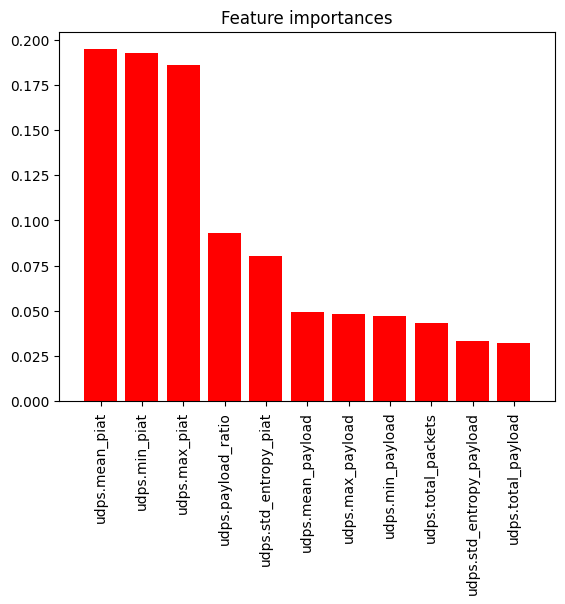

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

label_encoder = LabelEncoder()

df_using = df_filtered.copy(deep=True)
df_using['label_encoded'] = label_encoder.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

extra = ExtraTreesClassifier(random_state=420)

extra.fit(scaled_X, y)

importances = extra.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Decision Tree

Train Accuracy: 0.9999930408640463
Validation Accuracy: 0.9998608172809264
              precision    recall  f1-score   support

         VPN       0.95      1.00      0.97        89
     non-VPN       1.00      1.00      1.00     35835

    accuracy                           1.00     35924
   macro avg       0.97      1.00      0.99     35924
weighted avg       1.00      1.00      1.00     35924



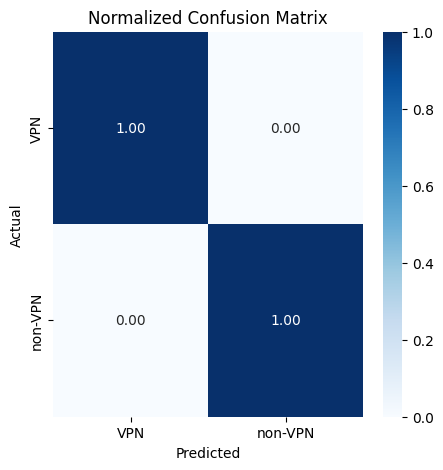

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df_using = df_filtered.copy(deep=True)
le = LabelEncoder()
df_using['label_encoded'] = le.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

clf = DecisionTreeClassifier(random_state=69)

clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
val_predictions = clf.predict(X_val)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

dt_report = classification_report(y_val, val_predictions, target_names=le.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=le.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

## Visualizing the decision tree

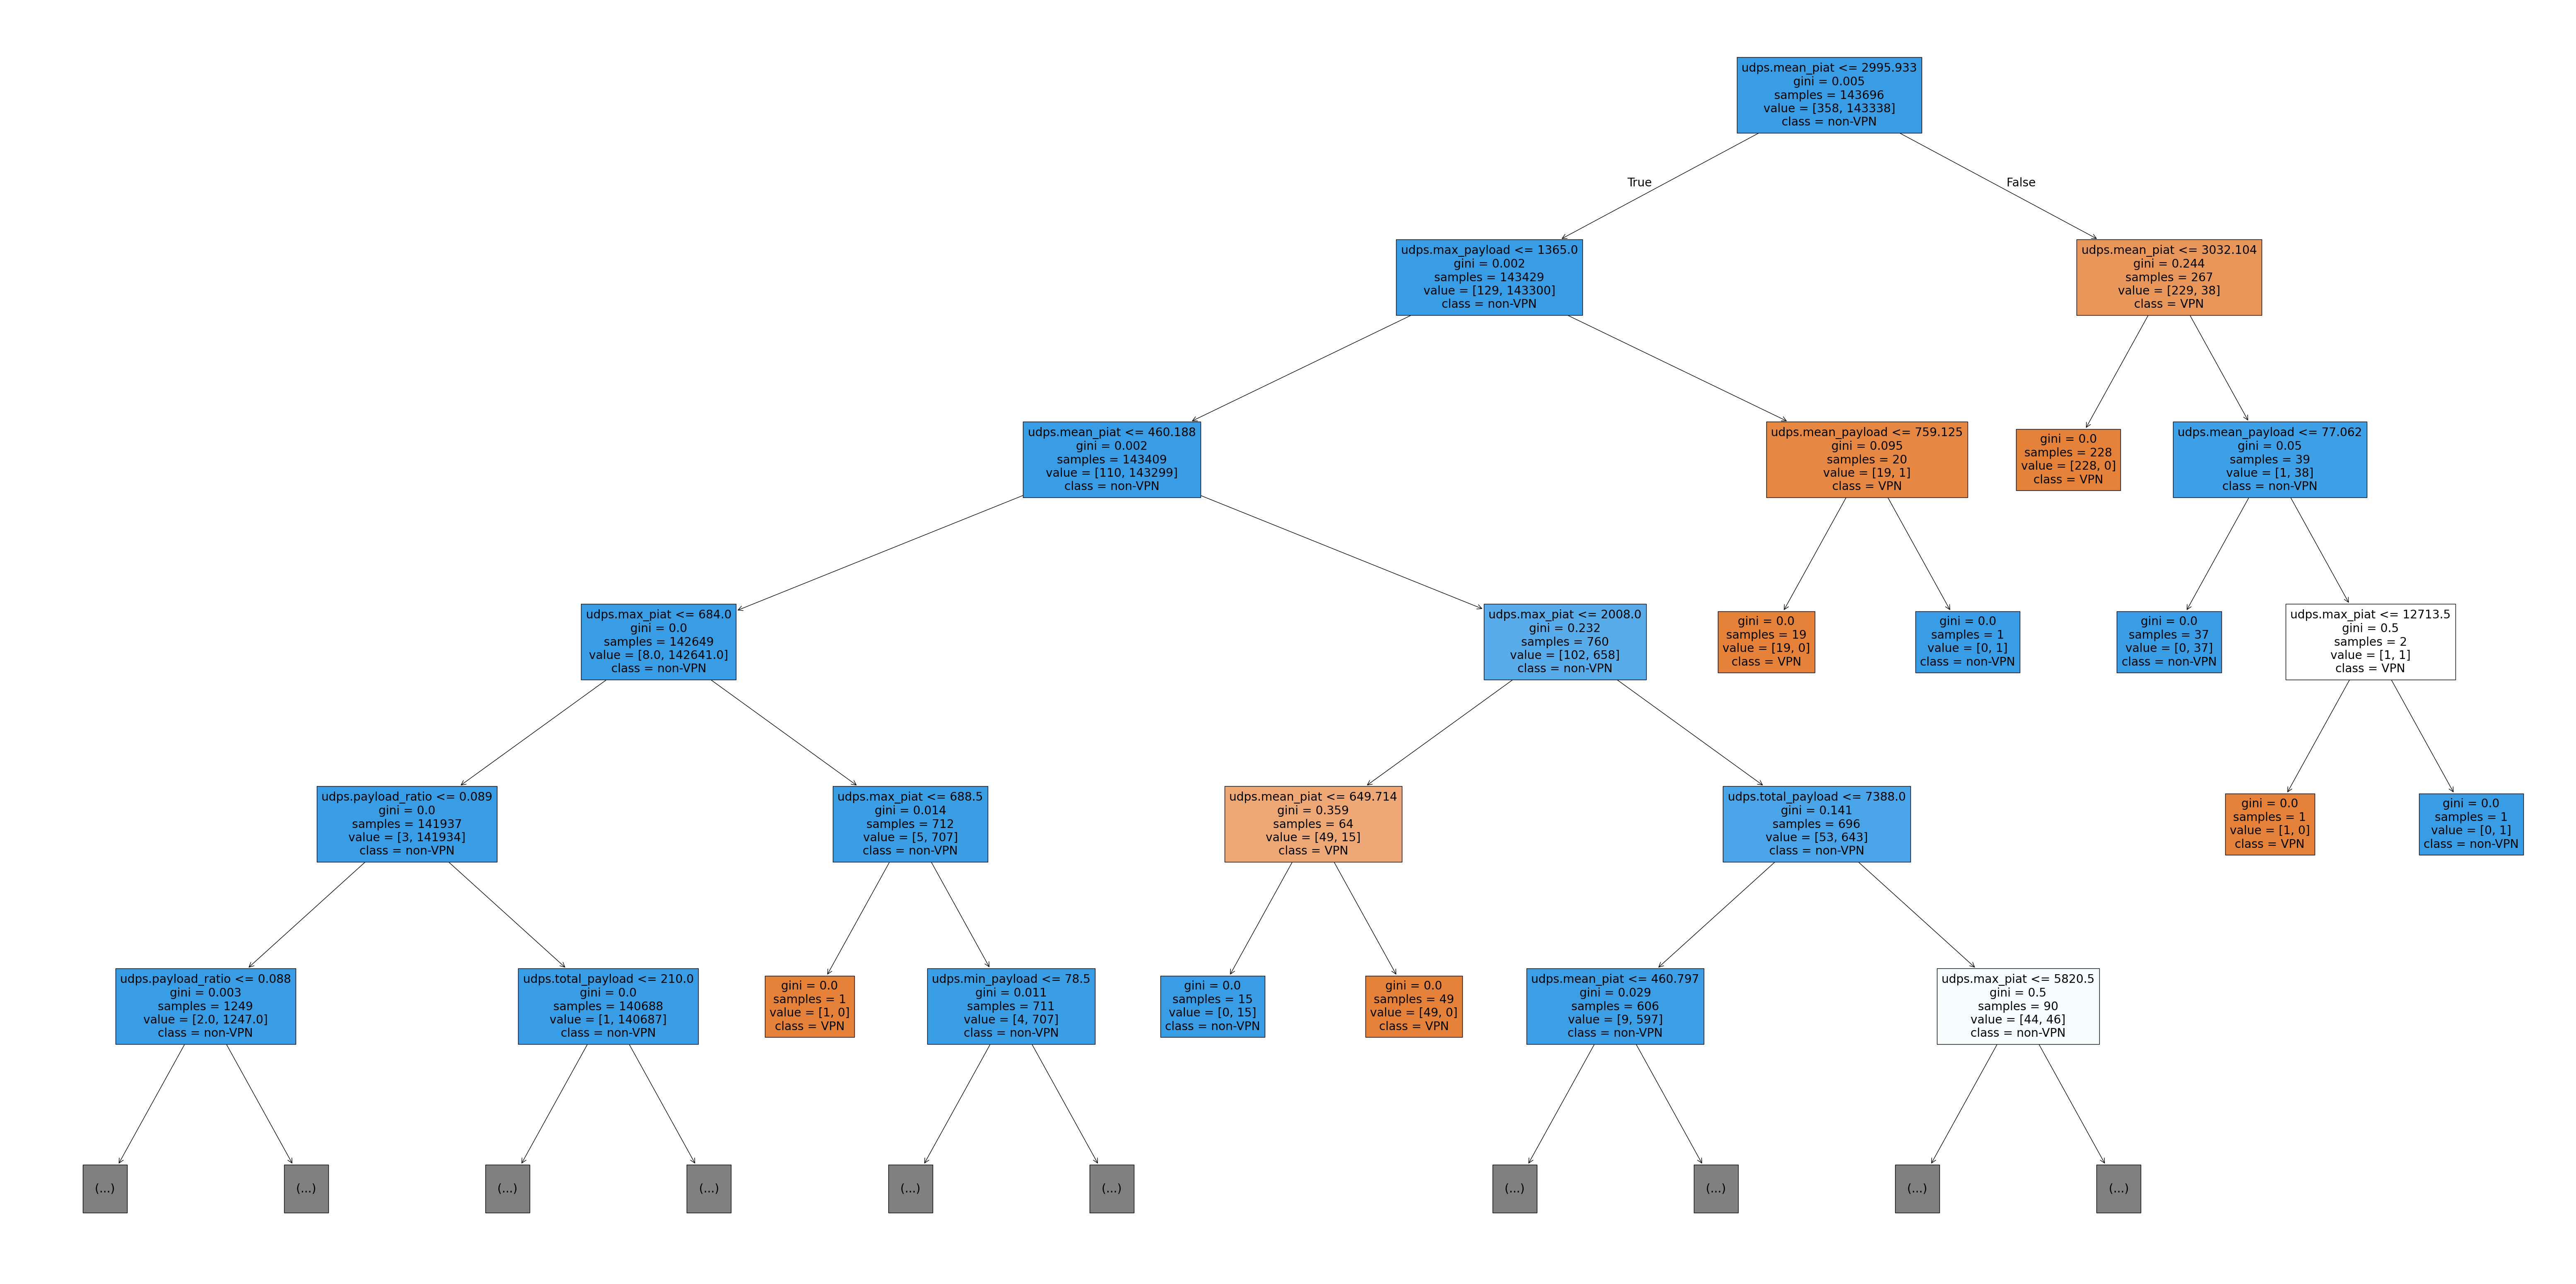

In [7]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 40))
plot_tree(clf, max_depth=5, filled=True, feature_names=X.columns, class_names=[str(i) for i in le.classes_])
plt.show()

## Random Forest

Train Accuracy: 0.9999930408640463
Validation Accuracy: 1.0
              precision    recall  f1-score   support

         VPN       1.00      1.00      1.00        89
     non-VPN       1.00      1.00      1.00     35835

    accuracy                           1.00     35924
   macro avg       1.00      1.00      1.00     35924
weighted avg       1.00      1.00      1.00     35924



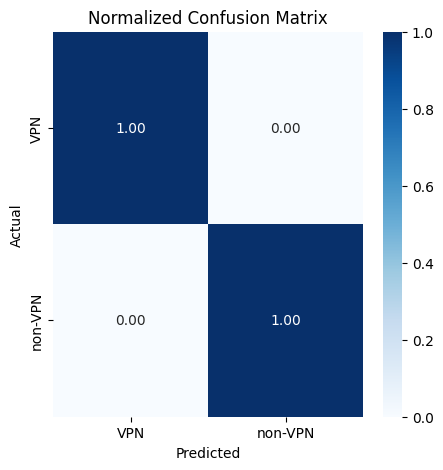

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_using = df_filtered.copy(deep=True)
label_encoder = LabelEncoder()
df_using['label_encoded'] = label_encoder.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

rf_clf = RandomForestClassifier(random_state=69)

rf_clf.fit(X_train, y_train)

train_predictions = rf_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f'Train Accuracy: {train_accuracy}')

val_predictions = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Validation Accuracy: {val_accuracy}')

rf_report = classification_report(y_val, val_predictions, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

## Neural Network

2024-11-26 00:00:49.905434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/zombi170/Documents/python/notebook_venv9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9962 - loss: 0.0248 - val_accuracy: 0.9996 - val_loss: 0.0019
Epoch 2/20
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 3/20
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 4/20
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 5/20
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 9.9841e-04
Epoch 6/20
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9996 - val_loss: 0.0011
Epoch 7/20
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 9.2979e-04
Epoch 8/20
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9997 - loss

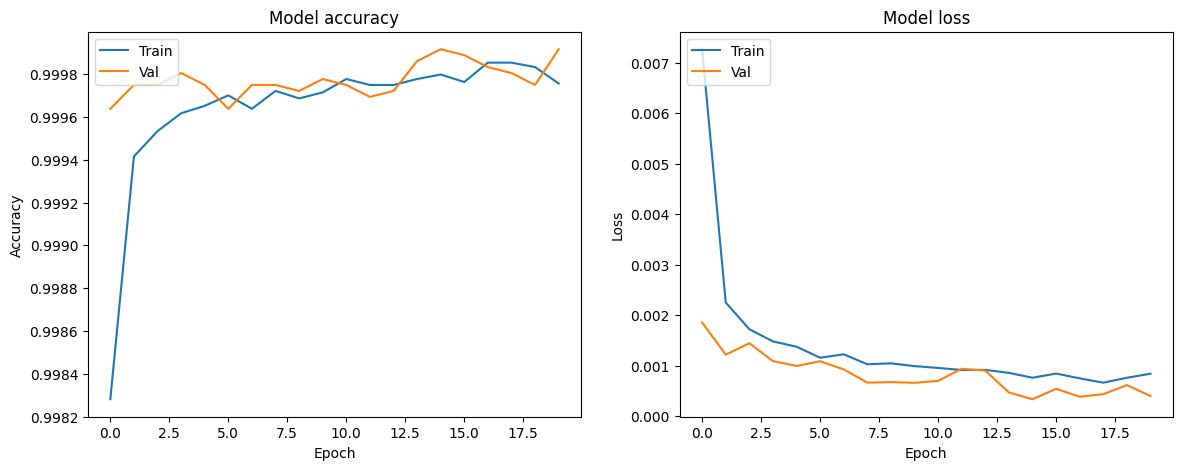

Train Accuracy: 0.9997564554214478
Validation Accuracy: 0.9999164938926697
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

         VPN       1.00      0.97      0.98        89
     non-VPN       1.00      1.00      1.00     35835

    accuracy                           1.00     35924
   macro avg       1.00      0.98      0.99     35924
weighted avg       1.00      1.00      1.00     35924



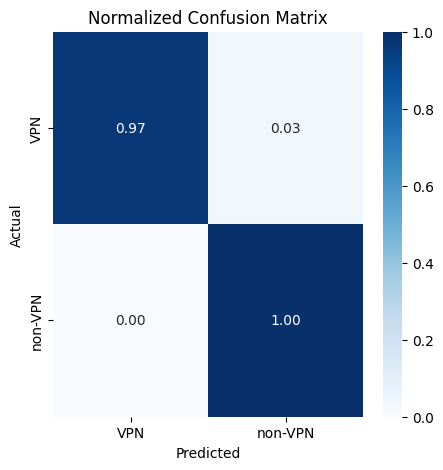

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_using = df_filtered.copy(deep=True)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(df_using[['VPN']])

X = df_using.drop(['VPN'], axis=1)
y = y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

model = Sequential([
    Dense(64, activation='relu', input_shape=(scaled_X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer with one neuron per class
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(scaled_X_train, y_train, epochs=20, validation_data=(scaled_X_val, y_val), callbacks=[early_stopping])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

train_accuracy = history.history['accuracy'][len(history.history['accuracy']) - 1]
print(f'Train Accuracy: {train_accuracy}')

val_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy']) - 1]
print(f'Validation Accuracy: {val_accuracy}')

y_pred = model.predict(scaled_X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

nn_report = classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0], output_dict=True)
print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))

cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

## Concatenating and writing out macro average data

In [10]:
from IPython.display import display

macro_avg_data = dt_report['macro avg']

df_macro_avg = pd.DataFrame.from_dict(macro_avg_data, orient='index').transpose()

df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(rf_report['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(nn_report['macro avg'], index=[0])], ignore_index=True)

accuracy_column = [dt_report['accuracy'], rf_report['accuracy'], nn_report['accuracy']]
df_accuracy = pd.DataFrame({'accuracy': accuracy_column})
df_macro_avg = pd.concat([df_accuracy, df_macro_avg], axis=1)

model_column = ['Decision Tree', 'Random Forest', 'Neural Network']
df_model = pd.DataFrame({'model': model_column})
df_macro_avg = pd.concat([df_model, df_macro_avg], axis=1)

df_macro_avg = df_macro_avg.drop(columns='support', axis=1)

display(df_macro_avg)

,model,accuracy,precision,recall,f1-score
0,Decision Tree,0.999861,0.973404,0.999930,0.986304
1,Random Forest,1.000000,1.000000,1.000000,1.000000
2,Neural Network,0.999916,0.999958,0.983146,0.991408
